In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

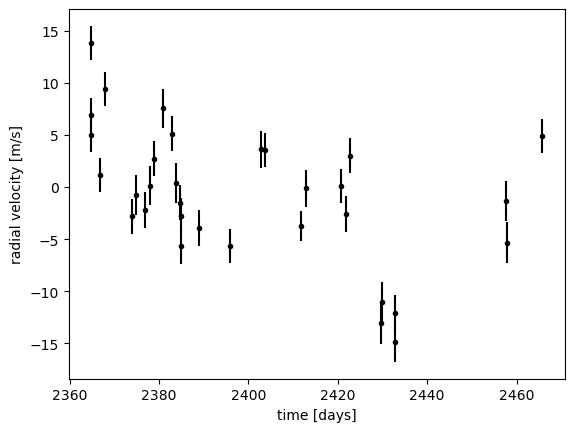

In [2]:
url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x.min() + x.max())

# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(x.min() - 5, x.max() + 5, 1000)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
_ = plt.ylabel("radial velocity [m/s]")

In [5]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


In [7]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt

with pm.Model() as model:

    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    logP = pm.Normal(
        "logP",
        mu=np.log(periods),
        sd=np.array(period_errs) / np.array(periods),
        shape=2,
        testval=np.log(periods),
    )
    P = pm.Deterministic("P", tt.exp(logP))

    # Wide log-normal prior for semi-amplitude
    logK = pm.Normal(
        "logK", mu=np.log(Ks), sd=2.0, shape=2, testval=np.log(Ks)
    )

    # Eccentricity & argument of periasteron
    ecs = pmx.UnitDisk("ecs", shape=(2, 2), testval=0.01 * np.ones((2, 2)))
    ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
    omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    xo.eccentricity.vaneylen19(
        "ecc_prior", multi=True, shape=2, fixed=True, observed=ecc
    )

    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)

    # Then we define the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=ecc, omega=omega)

    # And a function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
        pm.Deterministic("vrad" + name, vrad)

        # Define the background model
        A = np.vander(t - x_ref, 3)
        bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1) + bkg)

    # Define the RVs at the observed times
    rv_model = get_rv_model(x)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model
    err = tt.sqrt(yerr ** 2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)

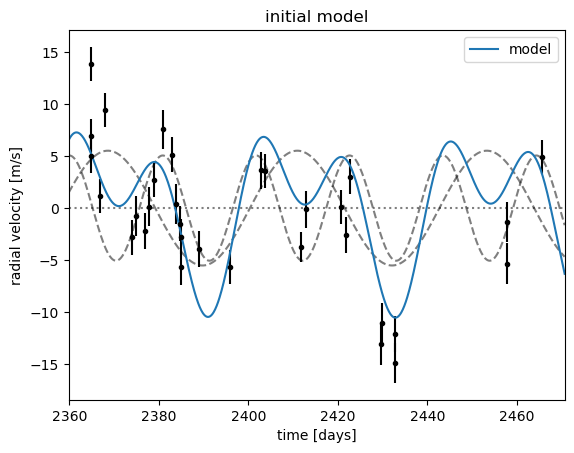

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, pmx.eval_in_model(model.vrad_pred), "--k", alpha=0.5)
    plt.plot(t, pmx.eval_in_model(model.bkg_pred), ":k", alpha=0.5)
    plt.plot(t, pmx.eval_in_model(model.rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")

In [9]:
with model:
    map_soln = pmx.optimize(start=model.test_point, vars=[trend])
    map_soln = pmx.optimize(start=map_soln, vars=[t0, trend, logK, logP, logs])
    map_soln = pmx.optimize(start=map_soln, vars=[ecs])
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [trend]


message: Optimization terminated successfully.
logp: -80.97288662812193 -> -70.35515898381642
optimizing logp for variables: [logs, logP, logK, trend, t0]


message: Optimization terminated successfully.
logp: -70.35515898381642 -> -64.7534977649419


optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -64.7534977649419 -> -61.21591140892364


optimizing logp for variables: [trend, logs, ecc_prior, ecs, logK, logP, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -61.21591140892364 -> -58.90483786264477


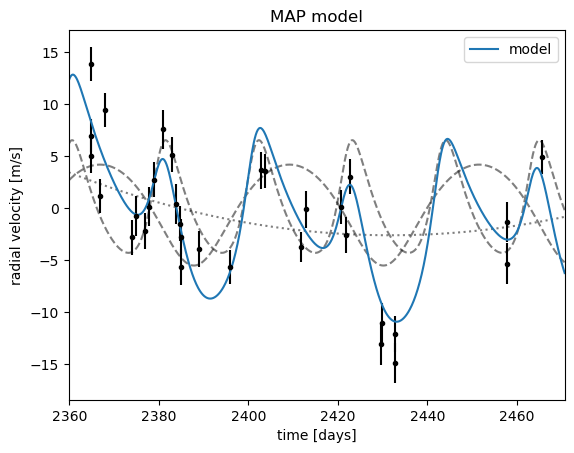

In [10]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("MAP model")

In [11]:
np.random.seed(42)
with model:
    trace = pmx.sample(
        tune=4000,
        draws=4000,
        cores=2,
        chains=2,
        target_accept=0.95,
    )

/Users/maxtalberg/miniconda3/envs/rv-env/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [trend, logs, ecc_prior, ecs, logK, logP, t0]


/Users/maxtalberg/miniconda3/envs/rv-env/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/maxtalberg/miniconda3/envs/rv-env/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [12]:
import arviz as az

az.summary(
    trace, var_names=["trend", "logs", "omega", "ecc", "t0", "logK", "P"]
)

/Users/maxtalberg/miniconda3/envs/rv-env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
trend[0],0.001,0.001,-0.001,0.002,0.000,0.000,5426.0,5426.0,5502.0,5080.0,1.0
trend[1],-0.039,0.022,-0.080,0.003,0.000,0.000,7452.0,6102.0,7504.0,5287.0,1.0
trend[2],-1.946,0.796,-3.359,-0.368,0.010,0.007,6147.0,6147.0,6201.0,5149.0,1.0
logs,1.039,0.226,0.607,1.458,0.004,0.003,3872.0,3872.0,4108.0,4969.0,1.0
omega[0],-0.296,0.783,-1.394,1.376,0.012,0.010,4216.0,2873.0,4553.0,3076.0,1.0
omega[1],-0.673,2.121,-3.099,2.919,0.027,0.020,6045.0,5649.0,6211.0,7372.0,1.0
ecc[0],0.234,0.113,0.000,0.414,0.002,0.001,4262.0,3574.0,4492.0,3984.0,1.0
ecc[1],0.199,0.148,0.000,0.468,0.003,0.002,2504.0,1962.0,3078.0,3058.0,1.0
t0[0],2072.795,0.001,2072.794,2072.796,0.000,0.000,8661.0,8661.0,8679.0,6401.0,1.0
t0[1],2082.625,0.000,2082.624,2082.626,0.000,0.000,8857.0,8857.0,8877.0,5695.0,1.0


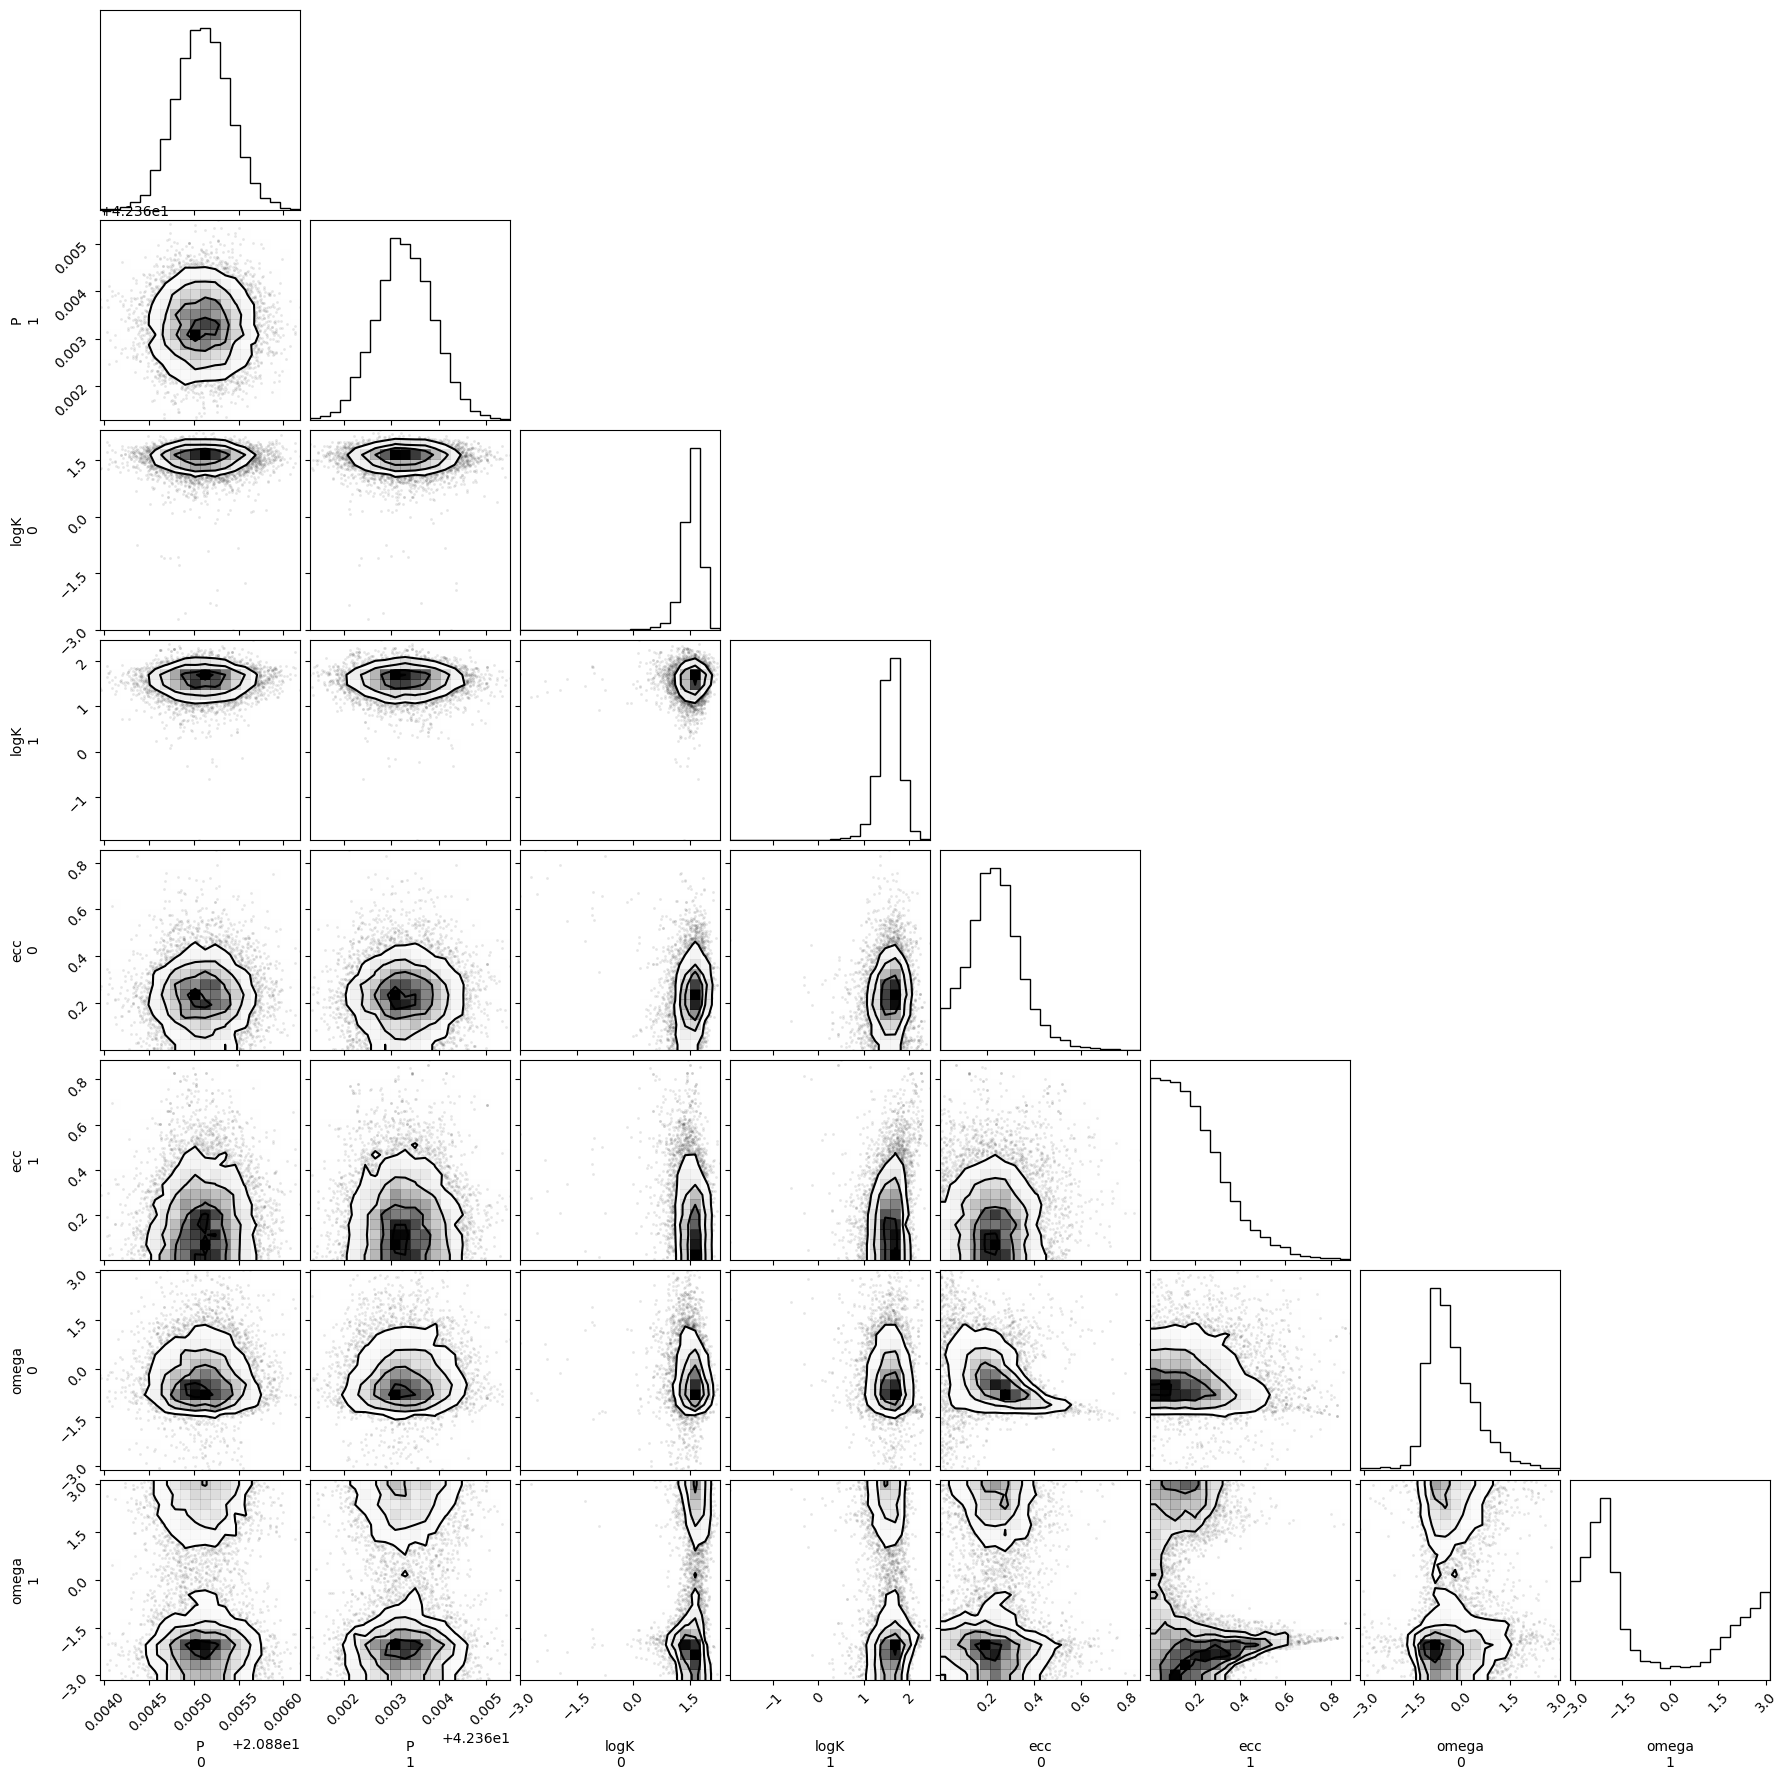

In [13]:
import corner

with model:
    _ = corner.corner(trace, var_names=["P", "logK", "ecc", "omega"])

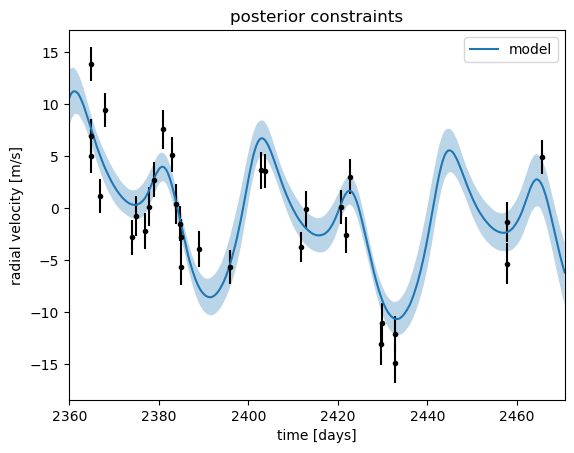

In [14]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("posterior constraints")

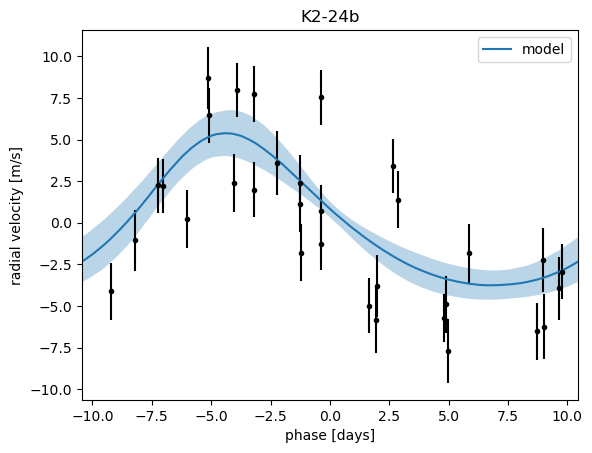

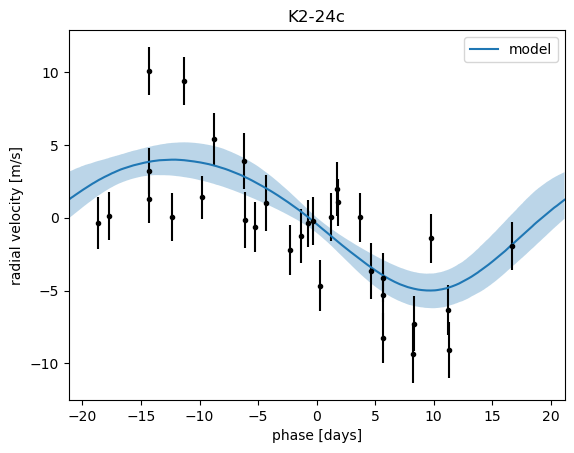

In [15]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["P"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(
        t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3
    )
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter))
